# Spanish Translation A/B Test

* Goal 1: Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Goal 2: Explain why that might be happening. Are the localized translations really worse?
* Goal 3: If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

## Table of Content

- Packages and Data
- 1 - Data Exploration
- 2 - Analysis and Discussion
- 3 - Algorithm

## Packages and Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [2]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [3]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


## Data Exploration

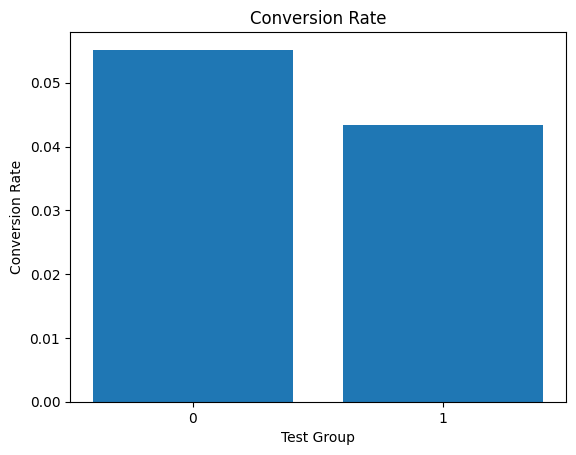

In [4]:
original_conversion_rate = test[test['test'] == 0]['conversion'].sum() / len(test[test['test'] == 0])
test_conversion_rate = test[test['test'] == 1]['conversion'].sum() / len(test[test['test'] == 1])

plt.bar(['0', '1'], [original_conversion_rate, test_conversion_rate])
plt.title('Conversion Rate')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.show()

In [5]:
raw_data = pd.merge(test, user, on='user_id', how='inner')
raw_data = raw_data[raw_data['country'] != 'Spain']

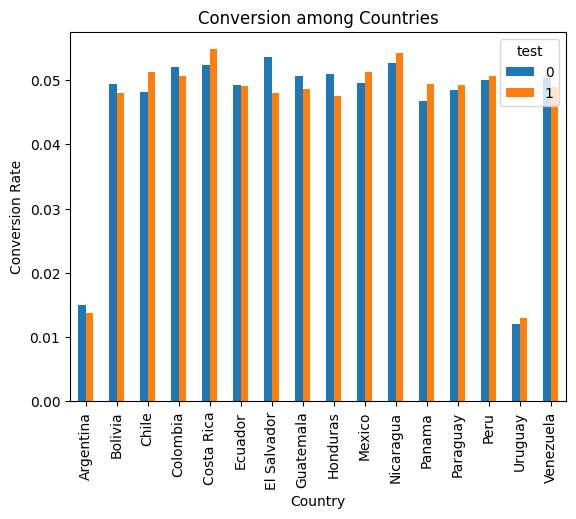

In [6]:
by_country = raw_data.groupby(['country', 'test'])['conversion'].agg(sum='sum', count='count')
by_country['conversion_rate'] = by_country['sum'] / by_country['count']

by_country['conversion_rate'].unstack().plot(kind='bar')
plt.title('Conversion among Countries')
plt.xlabel('Country')
plt.ylabel('Conversion Rate')
plt.show()

## Analysis and Discussion

In [7]:
count = [raw_data[raw_data['test'] == 0]['conversion'].sum(), raw_data[raw_data['test'] == 1]['conversion'].sum()]
nobs = [len(raw_data[raw_data['test'] == 0]), len(raw_data[raw_data['test'] == 1])]
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(stat))
print('{0:0.3f}'.format(pval))

7.382
0.000


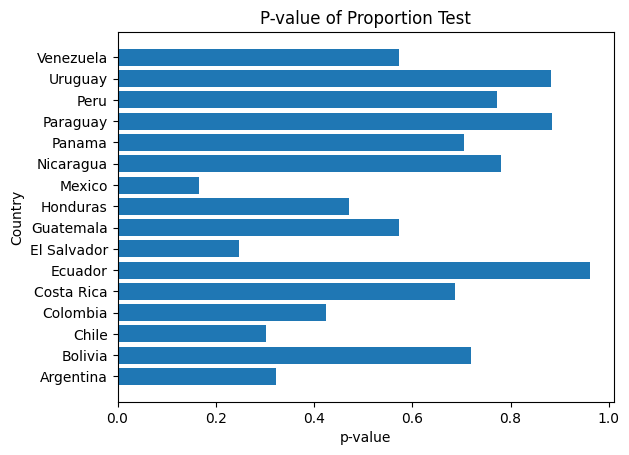

In [14]:
test_stats = list()
for country in by_country.index.get_level_values('country').unique():
    country_stats = by_country.loc[country]
    count = [country_stats.loc[0]['sum'], country_stats.loc[1]['sum']]
    nobs = [country_stats.loc[0]['count'], country_stats.loc[1]['count']]
    stat, pval = proportions_ztest(count, nobs)
    test_stats.append([country, stat, pval])

by_country_stats = pd.DataFrame(test_stats, columns=['country', 'test statistcs', 'p-value'])
plt.barh(by_country_stats['country'], by_country_stats['p-value'])
plt.title('P-value of Proportion Test')
plt.xlabel('p-value')
plt.ylabel('Country')
plt.show()

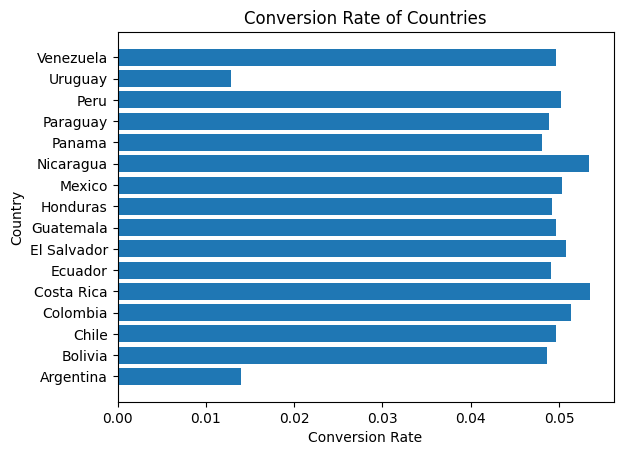

In [13]:
country = raw_data.groupby('country')['conversion'].agg(sum='sum', count='count')
country['conversion_rate'] = country['sum'] / country['count']
plt.barh(country.index, country['conversion_rate'])
plt.title('Conversion Rate of Countries')
plt.xlabel('Conversion Rate')
plt.ylabel('Country')
plt.show()

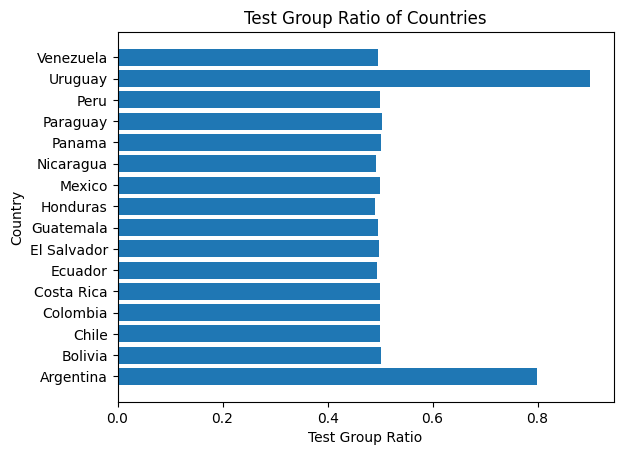

In [15]:
country = raw_data.groupby('country')['test'].agg(sum = 'sum', count='count')
country['test_rate'] = country['sum'] / country['count']
country['control_rate'] = 1 - country['test_rate']
plt.barh(country.index, country['test_rate'])
plt.title('Test Group Ratio of Countries')
plt.xlabel('Test Group Ratio')
plt.ylabel('Country')
plt.show()

## Algorithm

In [18]:
def run_proportion_test(data: pd.DataFrame, variable: str):
    """"""
    by_variable = data.groupby([variable, 'test'])['conversion'].agg(sum='sum', count='count')
    by_variable['conversion_rate'] = by_variable['sum'] / by_variable['count']

    test_stats = list()
    for cat in by_variable.index.get_level_values(variable).unique():
        cat_stats = by_variable.loc[cat]
        count = [cat_stats.loc[0]['sum'], cat_stats.loc[1]['sum']]
        nobs = [cat_stats.loc[0]['count'], cat_stats.loc[1]['count']]
        stat, pval = proportions_ztest(count, nobs)
        test_stats.append([cat, stat, pval])
    
    by_variable_stats = pd.DataFrame(test_stats, columns=['country', 'test statistcs', 'p-value'])
    if (by_variable_stats['p-value'] <= 0.05).sum() == 0:
        return 'no effect'
    elif (by_variable_stats['p-value'] > 0.05).sum() == 0 and (by_variable_stats['test statistcs'] < 0).sum() == 0:
        return 'decrease'
    elif (by_variable_stats['p-value'] > 0.05).sum() == 0 and (by_variable_stats['test statistcs'] > 0).sum() == 0:
        return 'increase'
    else:
        return 'mixed effect'

In [19]:
def algorithm(data: pd.DataFrame, test_var: str) -> bool:
    """"""

    ### Perform Overall Proportion Test
    count = [data[data[test_var] == 0]['conversion'].sum(), data[data[test_var] == 1]['conversion'].sum()]
    nobs = [len(data[data[test_var] == 0]), len(data[data[test_var] == 1])]
    stat, pval = proportions_ztest(count, nobs)

    if pval > 0.05:
        result = 'no_effect'
    elif pval <= 0.05 and stat > 0:
        result = 'decrease'
    else:
        result = 'increase'
    print('The effect of test variable:', result)

    ### Perfrom Proportion Test by controlling one more categorical Variable
    col_result_list = list()
    for col in data.columns:
        if raw_data[col].dtypes == 'object' and raw_data[col].nunique() < 20:
            col_result = run_proportion_test(data, col)
            col_result_list.append([col, col_result])
    
    by_col_result = pd.DataFrame(col_result_list, columns=['col', 'result'])
    print('The effect of test variable after controlling one more variable:')
    print(by_col_result)
    if (by_col_result['result'] != result).sum() > 0:
        return False
    else:
        return True

In [20]:
algorithm(raw_data, 'test')

The effect of test variable: decrease
The effect of test variable after controlling one more variable:
                col        result
0              date      decrease
1            source      decrease
2            device      decrease
3  browser_language  mixed effect
4       ads_channel  mixed effect
5           browser  mixed effect
6               sex      decrease
7           country     no effect


False